# Avance 1 — EDA de Casos de Prueba (Cotizaciones/Pedidos)
**Equipo:** 3 • **Fecha:** 2025-09-29

Metricas en este Notebook: univariante (histos/boxplots), categóricas (barras),
bi/multivariante (correlación numérica + crosstab + Cramér’s V), preprocesamiento (faltantes, outliers, cardinalidad),
selección de características (2.1) para recuperación (TF-IDF + SVD con **fix robusto**), y export limpio.


# Resumen ejecutivo (alcance ajustado)

Tras una reunión con asesores de IBM, se reduce el alcance del Proyecto Integrador para enfocarlo en el proyecto más relevante de Castor (metalurgia para construcción). En esta entrega solo se trabaja en Regression Test Selection (RTS) y, si el tiempo lo permite, en un asistente de Pull Request (PR) con IBM Watson. El resto de componentes queda como trabajo futuro.

## Nombre del proyecto

Plataforma de calidad aumentada por IA

## Contexto de la empresa

Castor (Medellín, Colombia) desarrolla software y UX/UI. Para este PI se centra exclusivamente en metalurgia para construcción, por ser el proyecto de mayor impacto.

## Alcance actual (máximo entregable de esta entrega)

Disparo por PR (simulado): La creación de un PR activa el pipeline CI/CD y registra metadatos (Jira/Azure DevOps, simulado).

Integración con IBM (por definir servicios): El pipeline envía datos del cambio de código a IBM Cloud para su procesamiento.

Modelo de RTS: Un modelo selecciona el subconjunto óptimo de casos de prueba a ejecutar a partir de archivos modificados y características del cambio.

Asistente de PR (opcional, si alcanza): Agente basado en IBM Watson (p.ej., Discovery + RAG) para resúmenes/sugerencias sobre el PR usando documentación interna.

## Fuera de alcance en esta entrega (quedará como futuro/simulado)

Ejecución real + retroalimentación: resultados, detección de flaky tests y reentrenamiento.

Publicación consolidada en el PR (análisis estático, riesgo de defectos, resultados y sugerencias) y actualización en Jira/Azure DevOps.

Dashboard DORA para monitoreo estratégico.

Modelo de evaluación de riesgo de cambios (queda para fase posterior).

## 0) Configuración y carga de datos

In [2]:
from __future__ import annotations
import re, json, sys, time, platform, hashlib, warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (8,5)})

@dataclass
class Config:
    # Paths
    RAW_TESTS: Path = Path("../data/raw/TestCases.csv")
    RAW_CHANGED: Path = Path("../data/raw/ChangedFiles.csv")
    RAW_META: Path = Path("../data/raw/PipelineMeta.csv")
    OUT_DIR: Path = Path("../data/processed")
    RUN_DIR: Path = Path("../run_artifacts")
    # Behavior
    MAKE_PLOTS: bool = True
    USE_SVD: bool = False           # Desactivado: RTS no lo requiere (reduce tiempo/memoria)
    TOP_FRACTION: float = 0.15      # % de tests a seleccionar por PR
    TFIDF_MAX_FEATURES: int = 6000  # Dim TF-IDF
    LINES_NORM: int = 300           # Normalizador de tamaño de cambio
    # Pesos del score RTS
    W_SIM: float = 0.6
    W_MODULE: float = 0.2
    W_RISK: float = 0.1
    W_SIZE: float = 0.1

CFG = Config()
assert CFG.RAW_TESTS.exists(), f"No se encontró {CFG.RAW_TESTS}"
assert CFG.RAW_CHANGED.exists(), f"No se encontró {CFG.RAW_CHANGED}"
assert CFG.RAW_META.exists(), f"No se encontró {CFG.RAW_META}"
CFG.OUT_DIR.mkdir(parents=True, exist_ok=True)
CFG.RUN_DIR.mkdir(parents=True, exist_ok=True)


## 1) UTILIDADES: hashing, casting, gráficos

In [3]:
def sha256(path: Path) -> str | None:
    if not path.exists(): return None
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def to_numeric(series: pd.Series) -> pd.Series:
    # vectorizado: cambia coma decimal y convierte; errores -> NaN
    return pd.to_numeric(series.astype(str).str.replace(",", ".", regex=False), errors="coerce")

def bar(series: pd.Series, title: str, xlabel: str):
    ax = series.plot(kind="bar")
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("conteo")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

def hist(series: pd.Series, title: str, xlabel: str, bins=30):
    series.plot(kind="hist", bins=bins, alpha=0.85)
    plt.title(title); plt.xlabel(xlabel); plt.tight_layout(); plt.show()


## 2) CARGA + NORMALIZACIÓN (vectorizado)

In [13]:
ALIAS: Dict[str, List[str]] = {
    "case_id": ["case_id","id","Id","ID","codigo","código","id caso","id_cp","id cp"],
    "title": ["title","titulo","título","nombre cp","nombre_cp","nombre del caso","nombre","NOMBRE CP","NOMBRE"],
    "preconditions": ["preconditions","precondiciones","pre-condiciones","precondición","precondicion","precondiciones cp","Precondición"],
    "steps": ["steps","pasos","procedimiento","instrucciones","PASOS"],
    "expected_result": ["expected_result","resultado_esperado","resultado esperado","RESULTADO ESPERADO"],
    "obtained_result": ["obtained_result","resultado_obtenido","resultado obtenido","RESULTADO OBTENIDO"],
    "observations": ["observations","observaciones","notas","OBSERVACIONES"],
    "exec_count": ["# ejec","num_ejec","num ejec","ejecuciones","# ejecuciones","# EJEC","#EJEC"],
    "test_status": ["estado de la prueba","estado_prueba","resultado","estado","TEST STATUS","Estado de la prueba"],
    "feature_name": ["nombre de la funcionalidad","funcionalidad","feature","Nombre de la funcionalidad"],
    "sprint": ["sprint","iteracion","iteración","SPRINT"],
    "created_at": ["fecha de creación","fecha_creacion","creado","Fecha de creación"],
    "module": ["module","módulo","modulo","area","área","component","componente","modulo funcional"],
    "type": ["type","tipo","categoria","category","tipo de prueba","tipo prueba","clase de prueba"],
    "priority": ["priority","prioridad","severity","severidad"],
    "estimated_duration_min": ["estimated_duration_min","duracion_min","duración_min","duration","duracion","duración"],
}

TEXT_COLS = ["title","preconditions","steps","expected_result","obtained_result","observations"]

def rename_by_alias(df: pd.DataFrame, alias: Dict[str, List[str]]) -> pd.DataFrame:
    lower_map = {c.lower(): c for c in df.columns}
    rename_map = {}
    for std, options in alias.items():
        for opt in options:
            col = lower_map.get(opt.lower())
            if col:
                rename_map[col] = std; break
    return df.rename(columns=rename_map)

def load_and_clean_tests(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = rename_by_alias(df, ALIAS)

    # Texto: fillna y trim vectorizado
    for c in [x for x in TEXT_COLS + ["feature_name"] if x in df.columns]:
        df[c] = df[c].fillna("").astype(str).str.strip()

    # Categóricas: trim (y opcionalmente convertir a 'category' para memoria)
    for c in [x for x in ["module","type","priority","test_status","sprint"] if x in df.columns]:
        df[c] = df[c].astype(str).str.strip()

    # Numéricas
    if "exec_count" in df.columns:
        df["exec_count"] = to_numeric(df["exec_count"]).astype("float")
    if "estimated_duration_min" in df.columns:
        df["estimated_duration_min"] = to_numeric(df["estimated_duration_min"]).astype("float")

    # Duplicados exactos (rápido, estable)
    df = df.drop_duplicates()

    # Longitudes (vectorizado)
    for c in [x for x in TEXT_COLS if x in df.columns]:
        df[f"{c}_len"] = df[c].str.len()

    return df

df = load_and_clean_tests(CFG.RAW_TESTS)
print("Shape:", df.shape)
display(df.head(4))

Shape: (4, 19)


,case_id,title,preconditions,steps,expected_result,obtained_result,observations,exec_count,test_status,feature_name,sprint,created_at,module,title_len,preconditions_len,steps_len,expected_result_len,obtained_result_len,observations_len
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,Haber accedido al 'Portal de Clientes',"1) Filtrar el cliente por RNC, nombre o Código...",La opción 'Cotización' aparece correctamente e...,La opción 'Cotización' aparece correctamente e...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones,102,38,200,66,66,0
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El usuario es redirigido correctamente a la pá...,El usuario es redirigido correctamente a la pá...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones,69,75,59,67,67,0
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,La página de Cotizaciones carga correctamente ...,La página de Cotizaciones no carga correctamen...,La página se tarda en cargar,2.0,Falló en su ejecución,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones,55,75,59,87,90,28
3,1-HU1-4,Contenido correcto en la página de Cotizacione...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El contenido de la página de Cotizaciones es v...,El contenido de la página de Cotizaciones es v...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1,2025-01-03,Cotizaciones,67,75,113,64,64,0


##  3) STATUS + MÓDULO INFERIDO (sin apply row-wise)

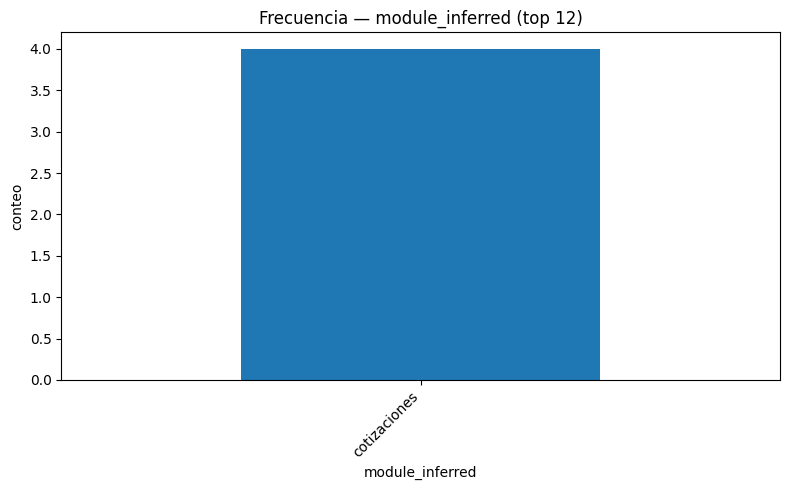

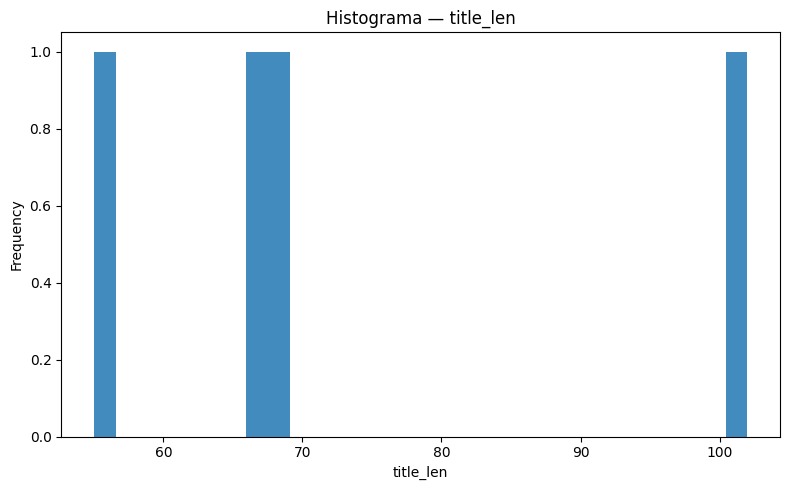

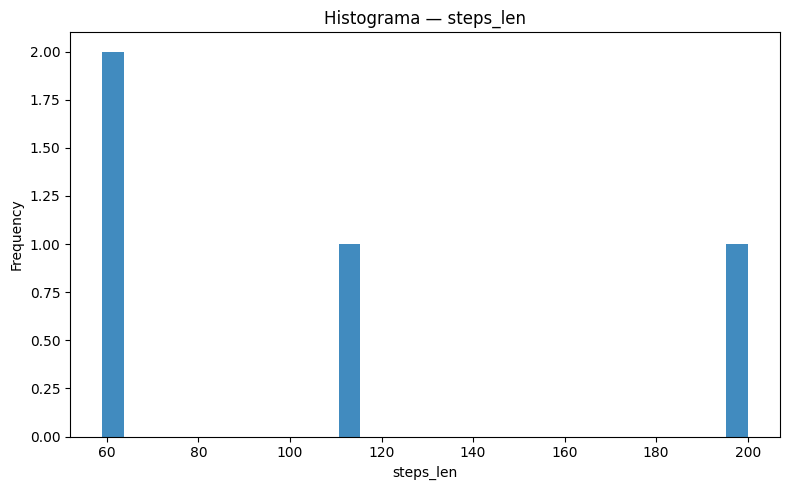

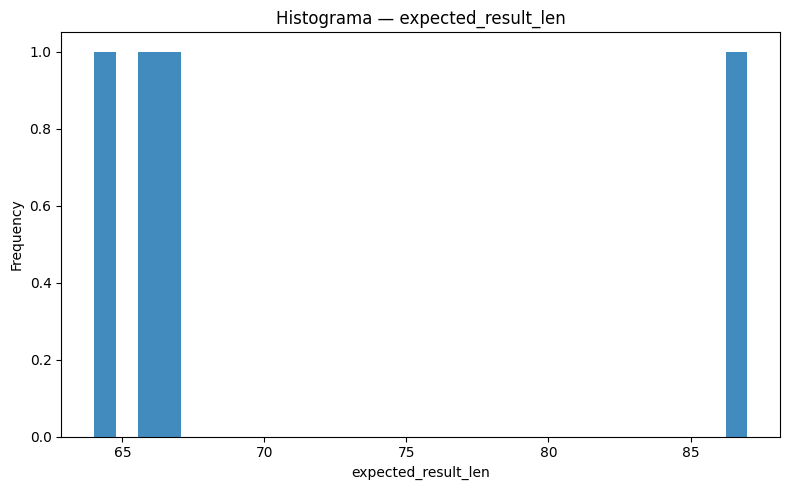

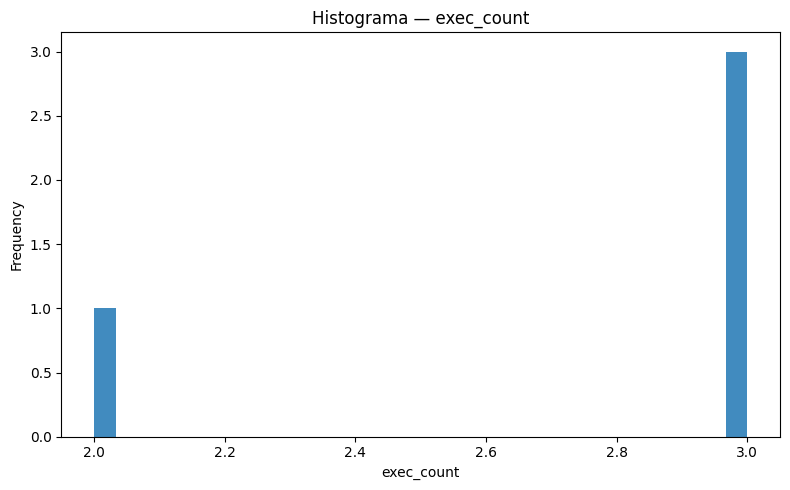

In [15]:
STATUS_MAP = {
    "ejecución exitosa":"pass","ejecucion exitosa":"pass","ok":"pass","exitoso":"pass","exitosamente":"pass",
    "falló en su ejecución":"fail","fallo en su ejecucion":"fail","falló":"fail","fail":"fail","no cumple":"fail",
    "no se ejecutó":"not_run","no se ejecuto":"not_run","pendiente":"not_run",
    "el componente no esta listo":"blocked","bloqueada":"blocked","bloqueado":"blocked"
}

def normalize_status_col(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.strip().str.lower()
    mapped = s.map(STATUS_MAP)

    mask_unset = mapped.isna()

    mapped.loc[mask_unset & s.str.contains(r"(exitosa|exitos|^ok$)", regex=True)] = "pass"
    mapped.loc[mask_unset & s.str.contains(r"(fall|error)", regex=True)]           = "fail"
    mapped.loc[mask_unset & s.str.contains(r"(no se ejec|pend)", regex=True)]     = "not_run"
    mapped.loc[mask_unset & s.str.contains(r"(bloque|no est[aá] listo)", regex=True)] = "blocked"

    return mapped


df["status_std"] = normalize_status_col(df["test_status"]) if "test_status" in df.columns else np.nan

def infer_module_fast(df: pd.DataFrame) -> pd.Series:
    # Texto agregado para heurística
    base = (
        df.get("module", "").astype(str).str.lower().str.strip() + " " +
        df.get("feature_name", "").astype(str).str.lower() + " " +
        df.get("title", "").astype(str).str.lower() + " " +
        df.get("steps", "").astype(str).str.lower()
    )
    conds = [
        base.str.contains("cotizacion|cotización|cotizaciones", regex=True),
        base.str.contains(r"\bpedido(s)?\b", regex=True),
        base.str.contains("precio(s)?", regex=True),
        base.str.contains("impuesto(s)?", regex=True),
        base.str.contains("cliente(s)?", regex=True),
    ]
    choices = ["cotizaciones","pedidos","precios","impuestos","clientes"]
    inferred = np.select(conds, choices, default="otros")
    # prioriza 'module' explícito si existe
    module_explicit = df.get("module")
    if module_explicit is not None:
        m = module_explicit.astype(str).str.lower().str.strip()
        inferred = np.where(m.ne(""), m, inferred)
    return pd.Series(inferred, index=df.index)

df["module_inferred"] = infer_module_fast(df)

# Gráficos mínimos útiles para RTS
if CFG.MAKE_PLOTS:
    bar(df["module_inferred"].value_counts().head(12), "Frecuencia — module_inferred (top 12)", "module_inferred")
    for c in [x for x in ["title_len","steps_len","expected_result_len","exec_count"] if x in df.columns]:
        hist(df[c].dropna(), f"Histograma — {c}", c, bins=30)


## 4) OUTLIERS LIGEROS

In [16]:
if "estimated_duration_min" in df.columns:
    q01, q99 = df["estimated_duration_min"].quantile([0.01, 0.99])
    df["estimated_duration_min"] = df["estimated_duration_min"].clip(q01, q99)
    if df["estimated_duration_min"].skew() > 1:
        df["estimated_duration_min_log1p"] = np.log1p(df["estimated_duration_min"])


## 5) TEXTO COMPLETO (1 pasada)

In [17]:
for c in TEXT_COLS:
    if c not in df.columns: df[c] = ""
df["text_full"] = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)

# Guardado básico de features limpias (útil para auditoría)
keep_cols = [
    "case_id","title","preconditions","steps","expected_result","obtained_result","observations",
    "feature_name","sprint","created_at",
    "module","module_inferred","type","priority","exec_count","test_status","status_std",
    "estimated_duration_min","estimated_duration_min_log1p",
    "title_len","steps_len","expected_result_len","obtained_result_len","preconditions_len","observations_len",
]
keep_cols = [c for c in keep_cols if c in df.columns]
df[keep_cols + ["text_full"]].to_csv(CFG.OUT_DIR / "TestCases_clean_features.csv", index=False)


## 6) DATOS DEL PR (ChangedFiles + PipelineMeta) => documento por PR

In [19]:
cf = pd.read_csv(CFG.RAW_CHANGED)
pm = pd.read_csv(CFG.RAW_META)

for f in (cf, pm):
    for c in f.columns:
        if f[c].dtype == "O":
            f[c] = f[c].astype(str).str.strip()

def path_tokens(path: str) -> str:
    s = re.sub(r"[^a-zA-Z0-9_/.\-]", " ", str(path))
    parts = re.split(r"[/_.\-]+", s.lower())
    parts = [p for p in parts if p and len(p) > 1]
    return " ".join(parts)

pr_docs = (
    cf.assign(file_tokens=cf["file_path"].map(path_tokens))
      .groupby("pr_id")
      .agg(file_tokens=("file_tokens", " ".join),
           modules_str=("module", lambda s: " ".join(map(str, s))),
           lines_added=("lines_added","sum"),
           lines_deleted=("lines_deleted","sum"))
      .join(pm.set_index("pr_id")[["pr_title","pr_desc","severity_declared","has_db_migration","changed_files"]], how="left")
      .fillna({"pr_title":"","pr_desc":"","modules_str":"","file_tokens":""})
)

pr_docs["pr_text"] = pr_docs["pr_title"]+" "+pr_docs["pr_desc"]+" "+pr_docs["file_tokens"]+" "+pr_docs["modules_str"]
pr_docs["total_lines_changed"] = (pr_docs["lines_added"].fillna(0) + pr_docs["lines_deleted"].fillna(0)).astype(int)
display(pr_docs.head(4))


,file_tokens,modules_str,lines_added,lines_deleted,pr_title,pr_desc,severity_declared,has_db_migration,changed_files,pr_text,total_lines_changed
pr_id,,,,,,,,,,,
PR-1001,services precios taxes py api cotizaciones end...,cotizaciones cotizaciones cotizaciones,240,55,Ajuste cálculo de precios por IVA diferenciado,Se corrige el cálculo de impuestos para cotiza...,normal,no,3,Ajuste cálculo de precios por IVA diferenciado...,295
PR-1002,services pedidos validator py db migrations 20...,pedidos pedidos pedidos,115,38,Fix validación de clientes al crear pedido,Se agrega validación estricta y se crea índice...,critical,yes,3,Fix validación de clientes al crear pedido Se ...,153
PR-1003,ui clientes searchbar tsx services clientes re...,clientes clientes,45,17,Optimización de búsqueda de clientes,Se mejora la búsqueda por RNC y nombre y se re...,normal,no,2,Optimización de búsqueda de clientes Se mejora...,62


## 7) RTS CORE: vectorización conjunta + score rápido (sin bucles)

[RTS] PR-1001: top 5/4 | umbral=0.3609 -> ..\data\processed\RTS_selected_PR-1001.csv
[RTS] PR-1002: top 5/4 | umbral=0.1742 -> ..\data\processed\RTS_selected_PR-1002.csv


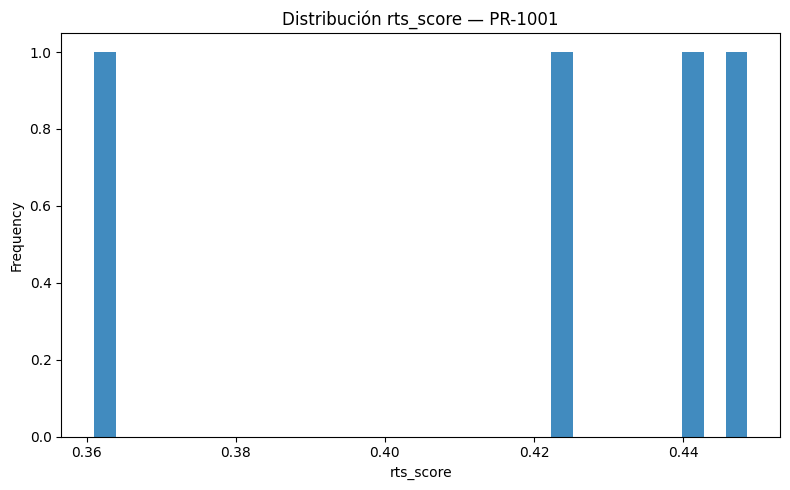

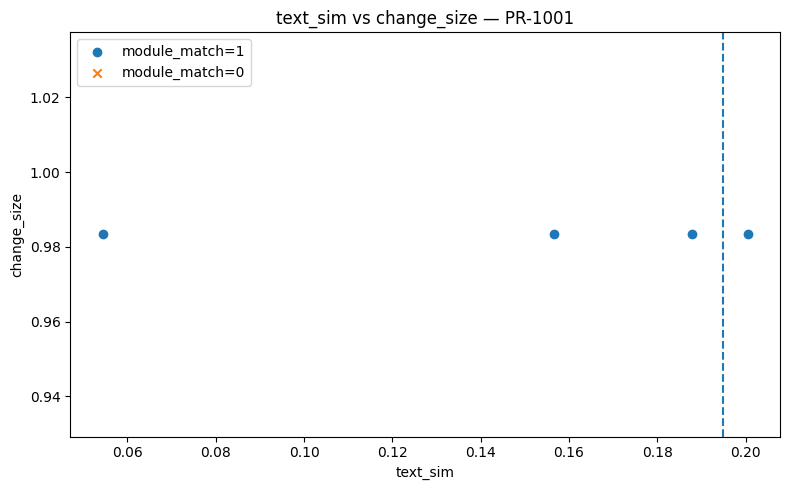

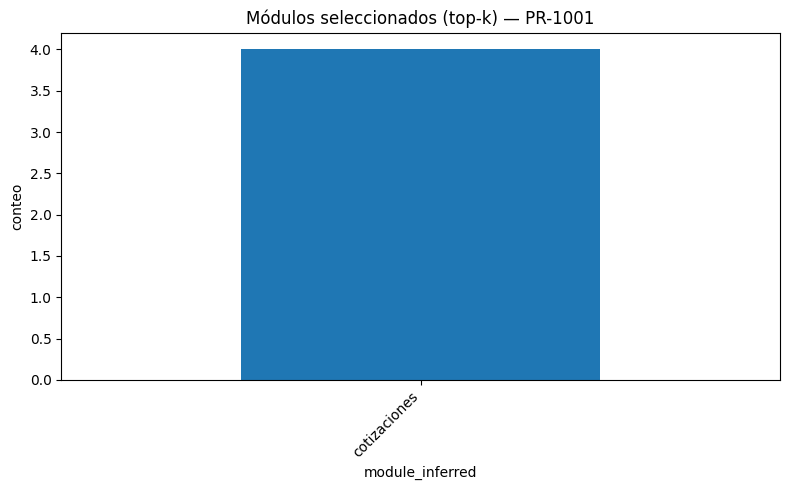

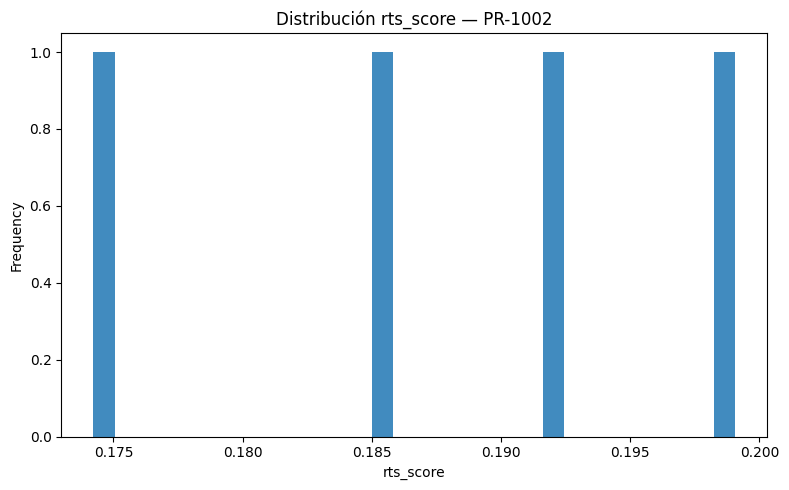

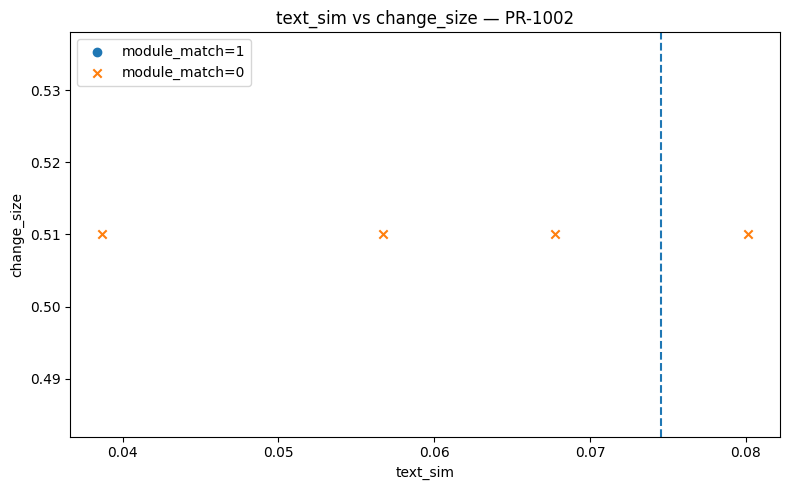

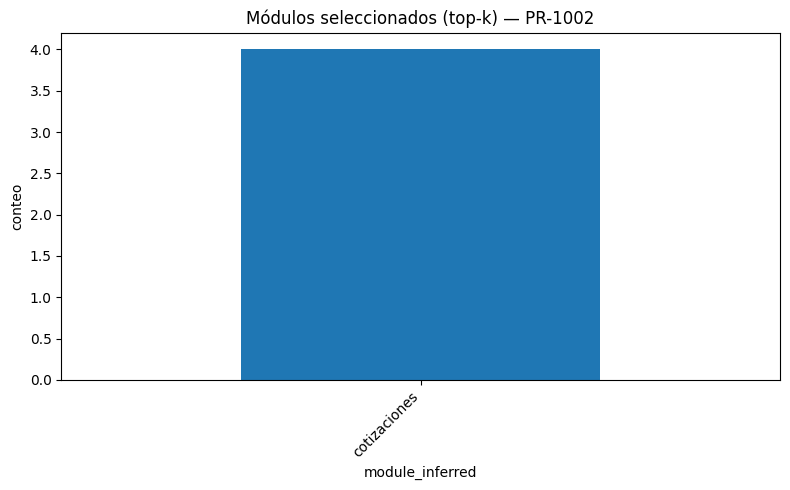

In [20]:
corpus_tests = df["text_full"].tolist()
corpus_prs = pr_docs["pr_text"].tolist()
vectorizer = TfidfVectorizer(max_features=CFG.TFIDF_MAX_FEATURES)
X = vectorizer.fit_transform(corpus_tests + corpus_prs)
X_tests = X[:len(corpus_tests)]
X_prs = X[len(corpus_tests):]

pr_index = {pid:i for i, pid in enumerate(pr_docs.index)}

def _severity_score(sev: str) -> float:
    sev = str(sev).lower()
    return {"critical":1.0,"high":0.7,"normal":0.3,"low":0.1}.get(sev, 0.3)

def rts_rank_for_pr(pr_id: str, top_frac: float = CFG.TOP_FRACTION) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    if pr_id not in pr_index:
        raise ValueError(f"pr_id '{pr_id}' no encontrado. Disponibles: {list(pr_index)[:5]} ...")
    j = pr_index[pr_id]
    y = X_prs[j]                            # vector PR
    sim = (X_tests @ y.T).toarray().ravel() # coseno (TF-IDF tiene L2 por defecto)

    # módulo_match vectorizado
    changed_mods = set(map(str.lower, cf.loc[cf["pr_id"]==pr_id, "module"].dropna().astype(str)))
    module_match = df["module_inferred"].str.lower().isin(changed_mods).astype(float).values

    # riesgo + tamaño normalizado
    row = pr_docs.loc[pr_id]
    risk = _severity_score(row.get("severity_declared","normal"))
    if str(row.get("has_db_migration","no")).lower() in {"yes","si","true","1"}:
        risk += 0.2
    risk = float(min(1.0, max(0.0, risk)))
    change_size = float(min(1.0, row.get("total_lines_changed", 0) / CFG.LINES_NORM))

    # score final (sin bucles)
    score = CFG.W_SIM*sim + CFG.W_MODULE*module_match + CFG.W_RISK*risk + CFG.W_SIZE*change_size

    full = df[["case_id","title","module_inferred"]].copy()
    full["text_sim"] = sim
    full["module_match"] = module_match
    full["risk"] = risk
    full["change_size"] = change_size
    full["rts_score"] = score
    full = full.sort_values("rts_score", ascending=False, kind="mergesort").reset_index(drop=True)
    full["rank"] = full.index + 1

    k = max(5, int(len(full)*top_frac))
    selected = full.head(k).copy()
    threshold = float(selected["rts_score"].min())
    out_path = CFG.OUT_DIR / f"RTS_selected_{pr_id}.csv"
    selected.to_csv(out_path, index=False)
    print(f"[RTS] {pr_id}: top {k}/{len(full)} | umbral={threshold:.4f} -> {out_path}")
    return selected, full, threshold

# Ejemplos
sel_1001, full_1001, thr_1001 = rts_rank_for_pr("PR-1001")
sel_1002, full_1002, thr_1002 = rts_rank_for_pr("PR-1002")

# Diagnósticos compactos
def plot_rts(pr_id: str, selected: pd.DataFrame, full: pd.DataFrame, thr: float):
    if not CFG.MAKE_PLOTS: return
    hist(full["rts_score"], f"Distribución rts_score — {pr_id}", "rts_score")
    # scatter por módulo_match
    mm = full["module_match"].values
    x, y = full["text_sim"].values, full["change_size"].values
    plt.scatter(x[mm==1], y[mm==1], marker="o", label="module_match=1")
    plt.scatter(x[mm==0], y[mm==0], marker="x", label="module_match=0")
    plt.axvline(np.percentile(full["text_sim"], 85), linestyle="--")  # referencia soft
    plt.title(f"text_sim vs change_size — {pr_id}")
    plt.xlabel("text_sim"); plt.ylabel("change_size"); plt.legend(); plt.tight_layout(); plt.show()
    # cobertura módulos
    bar(selected["module_inferred"].value_counts().head(10), f"Módulos seleccionados (top-k) — {pr_id}", "module_inferred")

plot_rts("PR-1001", sel_1001, full_1001, thr_1001)
plot_rts("PR-1002", sel_1002, full_1002, thr_1002)


## 8) EVIDENCIAS RUN (compacto)

In [21]:
report = {
    "timestamp_utc": time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
    "python": sys.version,
    "platform": platform.platform(),
    "raw_sha256": sha256(CFG.RAW_TESTS),
    "changed_sha256": sha256(CFG.RAW_CHANGED),
    "meta_sha256": sha256(CFG.RAW_META),
    "processed_exists": (CFG.OUT_DIR / "TestCases_clean_features.csv").exists(),
    "df_shape": tuple(df.shape),
    "examples": ["PR-1001","PR-1002"]
}
with open(CFG.RUN_DIR / "run_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
with open(CFG.RUN_DIR / "RUN_OK.txt", "w", encoding="utf-8") as f:
    f.write("RTS run OK\n")
print("✔ Evidencias en run_artifacts/")

✔ Evidencias en run_artifacts/


# 9) Reporte final — Inventario inicial vs. selección RTS por PR (no modifica nada previo)

In [23]:
from datetime import datetime
from pathlib import Path

def _call_rts_selector(pr_id: str, top_frac=None):
    # Usa rts_rank_for_pr si existe; si no, rts_score_for_pr
    if 'rts_rank_for_pr' in globals():
        return rts_rank_for_pr(pr_id, top_frac if top_frac is not None else CFG.TOP_FRACTION)
    elif 'rts_score_for_pr' in globals():
        # Para compatibilidad con versiones previas que devuelven solo 'selected'
        res = rts_score_for_pr(pr_id, top_frac if top_frac is not None else CFG.TOP_FRACTION)
        if isinstance(res, tuple) and len(res) == 3:
            return res
        else:
            # Convertimos a tupla (selected, full, threshold) mínima
            selected = res
            full = selected  # fallback sin full/threshold reales
            thr = float(selected["rts_score"].min()) if "rts_score" in selected.columns and not selected.empty else 0.0
            return selected, full, thr
    else:
        raise NameError("No se encontró ninguna función RTS (rts_rank_for_pr / rts_score_for_pr).")

def build_rts_report(pr_ids=None, top_frac=None, preview=10):
    assert 'df' in globals(), "No se encontró 'df'."
    init_cols = [c for c in ['case_id','title','module_inferred','module','feature_name','sprint'] if c in df.columns]
    initial = df[init_cols].copy().sort_values(by=init_cols[0] if init_cols else 'case_id')
    print(f"[RTS-Reporte] Casos iniciales totales: {len(initial)}")
    display(initial.head(preview))

    if pr_ids is None:
        assert 'pr_docs' in globals(), "No se encontró 'pr_docs'."
        pr_ids = list(pr_docs.index)

    selected_all, resumen = [], []
    for pid in pr_ids:
        try:
            sel, full, thr = _call_rts_selector(pid, top_frac=top_frac)
            sel = sel.copy()
            sel.insert(0, "pr_id", pid)
            selected_all.append(sel)
            resumen.append((pid, len(sel)))
        except Exception as e:
            print(f"[WARN] Falló la selección para {pid}: {e}")

    if selected_all:
        selected_all = pd.concat(selected_all, ignore_index=True)
    else:
        selected_all = pd.DataFrame(columns=['pr_id'] + init_cols)

    print("\n[RTS-Reporte] Resumen por PR (nº de casos seleccionados):")
    resumen_df = pd.DataFrame(resumen, columns=['pr_id','selected_count']).sort_values('pr_id')
    display(resumen_df)

    print("\n[RTS-Reporte] Muestra de seleccionados (top-k por PR):")
    display(selected_all.groupby('pr_id').head(min(10, len(selected_all))) if not selected_all.empty else selected_all)

    out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
    stamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    initial_csv = out_dir / f"RTS_initial_{stamp}.csv"
    selected_csv = out_dir / f"RTS_selected_all_{stamp}.csv"
    xlsx = out_dir / f"RTS_report_{stamp}.xlsx"

    initial.to_csv(initial_csv, index=False)
    if not selected_all.empty:
        selected_all.to_csv(selected_csv, index=False)

    try:
        import pandas as _pd
        with pd.ExcelWriter(xlsx) as w:
            initial.to_excel(w, index=False, sheet_name="initial_cases")
            selected_all.to_excel(w, index=False, sheet_name="selected_all")
            for pid, g in selected_all.groupby('pr_id'):
                g.to_excel(w, index=False, sheet_name=f"sel_{str(pid)[:25]}")
        excel_ok = True
    except Exception as e:
        print(f"[INFO] Excel no disponible ({e}). Se guardaron CSV.")
        excel_ok = False

    not_selected = initial[~initial['case_id'].isin(selected_all['case_id'])] if not selected_all.empty else initial.copy()
    print(f"\n[RTS-Reporte] Casos NO seleccionados (conteo): {len(not_selected)}")
    display(not_selected.head(min(10, len(not_selected))))

    print("\n[RTS-Reporte] Archivos generados en:", out_dir.as_posix())
    print("  -", initial_csv.name)
    if not selected_all.empty:
        print("  -", selected_csv.name)
    if excel_ok:
        print("  -", xlsx.name)

    return initial, selected_all, resumen_df, not_selected

# Ejecuta:
initial_cases, selected_cases, summary_by_pr, not_selected = build_rts_report()



[RTS-Reporte] Casos iniciales totales: 4


,case_id,title,module_inferred,module,feature_name,sprint
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1
3,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1


[RTS] PR-1001: top 5/4 | umbral=0.3609 -> ..\data\processed\RTS_selected_PR-1001.csv
[RTS] PR-1002: top 5/4 | umbral=0.1742 -> ..\data\processed\RTS_selected_PR-1002.csv
[RTS] PR-1003: top 5/4 | umbral=0.1351 -> ..\data\processed\RTS_selected_PR-1003.csv

[RTS-Reporte] Resumen por PR (nº de casos seleccionados):


,pr_id,selected_count
0,PR-1001,4
1,PR-1002,4
2,PR-1003,4



[RTS-Reporte] Muestra de seleccionados (top-k por PR):


,pr_id,case_id,title,module_inferred,text_sim,module_match,risk,change_size,rts_score,rank
0,PR-1001,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,0.200506,1.0,0.3,0.983333,0.448637,1
1,PR-1001,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,0.187819,1.0,0.3,0.983333,0.441025,2
2,PR-1001,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,0.156718,1.0,0.3,0.983333,0.422364,3
3,PR-1001,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,0.054361,1.0,0.3,0.983333,0.360950,4
4,PR-1002,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,0.080120,0.0,1.0,0.510000,0.199072,1
5,PR-1002,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,0.067745,0.0,1.0,0.510000,0.191647,2
6,PR-1002,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,0.056718,0.0,1.0,0.510000,0.185031,3
7,PR-1002,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,0.038709,0.0,1.0,0.510000,0.174226,4
8,PR-1003,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,0.194318,0.0,0.3,0.206667,0.167257,1
9,PR-1003,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,0.155254,0.0,0.3,0.206667,0.143819,2


[INFO] Excel no disponible (No module named 'openpyxl'). Se guardaron CSV.

[RTS-Reporte] Casos NO seleccionados (conteo): 0


,case_id,title,module_inferred,module,feature_name,sprint



[RTS-Reporte] Archivos generados en: ../data/processed
  - RTS_initial_20251003T161229Z.csv
  - RTS_selected_all_20251003T161229Z.csv
